# Objective:
# Implement the Singular Value Decomposition from scratch and apply it to two real-world problems: image compression and recommendation systems. You may use libraries for matrix manipulation (e.g., NumPy), but not for SVD computation—you must implement the algorithm manually.

**Part 1: Implementing SVD**


1.Write a Python function my_svd(A) that computes the SVD of a matrix A without

using any linear algebra libraries (like numpy.linalg.svd).

**Your implementation should:**

1.Compute the eigenvalues and eigenvectors of AᵀA to get V and Σ

2.Derive U from A, V, and Σ

3.Handle both rectangular and square matrices

4.Include appropriate checks for numerical stability

5.Test your function on small matrices (2x2, 3x3) and compare with numpy's implementation.





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as SklearnPCA

In [ ]:
def power_iteration(A, num_iterations=100, tol=1e-10):
    """Compute dominant eigenvalue and eigenvector using power iteration."""
    n = A.shape[0]
    v = np.random.rand(n)
    v = v / np.sqrt(v.dot(v))

    for _ in range(num_iterations):
        Av = A @ v
        eigenvalue = v.dot(Av)
        v_new = Av / np.sqrt(Av.dot(Av))

        if np.sqrt(((v_new - v)**2).sum()) < tol:
            return eigenvalue, v_new
        v = v_new

    return eigenvalue, v

In [ ]:
def deflate(A, eigenvalue, eigenvector):
    """Deflate matrix by removing contribution of an eigenvalue/eigenvector pair."""
    return A - eigenvalue * np.outer(eigenvector, eigenvector)


In [ ]:
def compute_eigenpairs(A, tol=1e-10):
    """Compute all eigenvalues and eigenvectors of a symmetric matrix."""
    n = A.shape[0]
    eigenvalues = []
    eigenvectors = np.zeros((n, n))
    A_temp = A.copy()

    for i in range(n):
        eigenvalue, eigenvector = power_iteration(A_temp)
        if abs(eigenvalue) < tol:
            break
        eigenvalues.append(eigenvalue)
        eigenvectors[:, i] = eigenvector
        A_temp = deflate(A_temp, eigenvalue, eigenvector)

    return np.array(eigenvalues), eigenvectors


In [ ]:
def gram_schmidt(V, tol=1e-10):
    """Orthogonalize columns of V using Gram-Schmidt."""
    U = V.copy()
    for i in range(V.shape[1]):
        u = U[:, i]
        for j in range(i):
            u -= np.dot(U[:, j], U[:, i]) * U[:, j]
        norm = np.sqrt(u.dot(u))
        if norm > tol:
            U[:, i] = u / norm
        else:
            U[:, i] = 0
    return U


In [ ]:
def my_svd(A, tol=1e-10):
    """Compute SVD of matrix A: A = U @ Sigma @ V.T"""
    A = np.array(A, dtype=float)
    m, n = A.shape

    # Compute AᵀA
    ATA = A.T @ A

    # Compute eigenvalues and eigenvectors of AᵀA
    eigenvalues, V = compute_eigenpairs(ATA)

    # Singular values are square roots of non-negative eigenvalues
    singular_values = np.sqrt(np.maximum(eigenvalues, 0))

    # Sort singular values and corresponding eigenvectors in descending order
    idx = np.argsort(singular_values)[::-1]
    singular_values = singular_values[idx]
    V = V[:, idx]

    # Compute rank
    rank = np.sum(singular_values > tol)

    # Compute Sigma
    Sigma = np.zeros((m, n))
    for i in range(min(rank, min(m, n))):
        Sigma[i, i] = singular_values[i]

    # Compute U
    U = np.zeros((m, m))  # Full m x m matrix
    for i in range(min(rank, min(m, n))):
        if singular_values[i] > tol:
            U[:, i] = (A @ V[:, i]) / singular_values[i]

    # Complete U with orthogonal vectors if rank < m
    if rank < m:
        # Use Gram-Schmidt to orthogonalize and fill remaining columns
        for i in range(rank, m):
            # Generate a random vector or use standard basis
            u = np.random.rand(m)
            U[:, i] = u
        U = gram_schmidt(U)

    # Ensure V is n x n for consistency
    if V.shape[1] < n:
        V_temp = np.zeros((n, n))
        V_temp[:, :V.shape[1]] = V
        for i in range(V.shape[1], n):
            V_temp[:, i] = np.random.rand(n)
        V = gram_schmidt(V_temp)

    return U, Sigma, V.T

In [ ]:
def test_svd():
    """Test my_svd against NumPy's SVD on small matrices."""
    # Test 1: 2x2 matrix
    A1 = np.array([[1, 2], [3, 4]])
    U1, S1, Vt1 = my_svd(A1)
    U_np1, S_np1, Vt_np1 = np.linalg.svd(A1, full_matrices=True)

    print("Test 1: 2x2 Matrix")
    print("Input array A1:\n", A1)
    print("My SVD singular values:", np.diag(S1))
    print("NumPy SVD singular values:", S_np1)
    print("Difference in singular values:", np.abs(np.diag(S1)[:len(S_np1)] - S_np1).max())

    # Reconstruct and compare
    A1_reconstructed = U1 @ S1 @ Vt1
    print("Reconstruction error:", np.abs(A1 - A1_reconstructed).max())

    # Test 2: 3x3 matrix
    A2 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    U2, S2, Vt2 = my_svd(A2)
    U_np2, S_np2, Vt_np2 = np.linalg.svd(A2, full_matrices=True)

    print("\nTest 2: 3x3 Matrix")
    print("Input array A2:\n", A2)
    print("My SVD singular values:", np.diag(S2))
    print("NumPy SVD singular values:", S_np2)
    print("Difference in singular values:", np.abs(np.diag(S2)[:len(S_np2)] - S_np2).max())

    # Reconstruct and compare
    A2_reconstructed = U2 @ S2 @ Vt2
    print("Reconstruction error:", np.abs(A2 - A2_reconstructed).max())

    # Test 3: 3x2 rectangular matrix
    A3 = np.array([[1, 2], [3, 4], [5, 6]])
    U3, S3, Vt3 = my_svd(A3)
    U_np3, S_np3, Vt_np3 = np.linalg.svd(A3, full_matrices=True)

    print("\nTest 3: 3x2 Matrix")
    print("Input array A3:\n", A3)
    print("My SVD singular values:", np.diag(S3)[:min(S3.shape)])
    print("NumPy SVD singular values:", S_np3)
    print("Difference in singular values:", np.abs(np.diag(S3)[:len(S_np3)] - S_np3).max())

    # Reconstruct and compare
    A3_reconstructed = U3 @ S3 @ Vt3
    print("Reconstruction error:", np.abs(A3 - A3_reconstructed).max())

In [ ]:
test_svd()

Test 1: 2x2 Matrix
Input array A1:
 [[1 2]
 [3 4]]
My SVD singular values: [5.4649857  0.36596619]
NumPy SVD singular values: [5.4649857  0.36596619]
Difference in singular values: 9.43689570931383e-16
Reconstruction error: 6.437961275196358e-11

Test 2: 3x3 Matrix
Input array A2:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
My SVD singular values: [16.84810335  1.06836951  0.        ]
NumPy SVD singular values: [1.68481034e+01 1.06836951e+00 4.41842475e-16]
Difference in singular values: 3.552713678800501e-15
Reconstruction error: 3.5864644587491057e-12

Test 3: 3x2 Matrix
Input array A3:
 [[1 2]
 [3 4]
 [5 6]]
My SVD singular values: [9.52551809 0.51430058]
NumPy SVD singular values: [9.52551809 0.51430058]
Difference in singular values: 2.55351295663786e-15
Reconstruction error: 1.0604850331219495e-12


**Part 2: Applications of SVD **

**Principal Component Analysis :**

1.Implement PCA using your SVD function.

2.Apply it to the Iris dataset and visualize the data projected onto the first two principal components.

3.Compare your results with sklearn's PCA implementation.


---



**Image Compression :**

1.Select a grayscale image (at least 256x256 pixels).

2.Write a function that compresses the image using truncated SVD at different compression levels (k=5, 10, 20, 50).

3.Display the original and compressed images side by side with their compression ratios and PSNR values.


---


**Recommendation System :**

1.Implement a simple movie recommendation system using SVD on the MovieLens 100k dataset.

2.Show how predictions change as you vary the number of singular values used.

In [ ]:
# PCA implementation
def my_pca(X, n_components=2):
    """Perform PCA using custom SVD."""
    # Standardize the data
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # Compute SVD
    U, Sigma, Vt = my_svd(X_std)

    # Principal components are rows of Vt (columns of V)
    components = Vt[:n_components]

    # Project data
    X_projected = X_std @ components.T

    # Explained variance ratio
    singular_values = np.diag(Sigma)
    explained_variance = singular_values**2 / (X_std.shape[0] - 1)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)

    return X_projected, components, explained_variance_ratio[:n_components]

In [ ]:
# Load and prepare Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

In [ ]:
# Apply custom PCA
X_projected_my, components_my, explained_variance_ratio_my = my_pca(X, n_components=2)

In [ ]:
# Apply scikit-learn PCA
pca_sklearn = SklearnPCA(n_components=2)
X_projected_sklearn = pca_sklearn.fit_transform(StandardScaler().fit_transform(X))
explained_variance_ratio_sklearn = pca_sklearn.explained_variance_ratio_

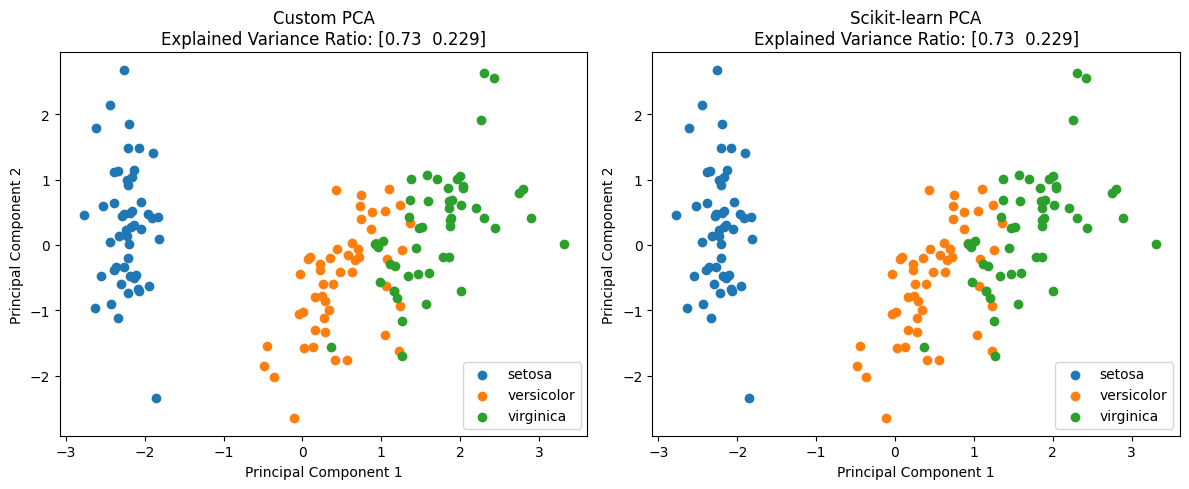

In [ ]:
# Visualize results
plt.figure(figsize=(12, 5))

# Custom PCA plot
plt.subplot(1, 2, 1)
for i, target_name in enumerate(target_names):
    plt.scatter(X_projected_my[y == i, 0], X_projected_my[y == i, 1], label=target_name)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Custom PCA\nExplained Variance Ratio: {explained_variance_ratio_my[:2].round(3)}')
plt.legend()

# Scikit-learn PCA plot
plt.subplot(1, 2, 2)
for i, target_name in enumerate(target_names):
    plt.scatter(X_projected_sklearn[y == i, 0], X_projected_sklearn[y == i, 1], label=target_name)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Scikit-learn PCA\nExplained Variance Ratio: {explained_variance_ratio_sklearn[:2].round(3)}')
plt.legend()

plt.tight_layout()

In [ ]:
# Compare results
print("Custom PCA Explained Variance Ratio:", explained_variance_ratio_my[:2])
print("Scikit-learn PCA Explained Variance Ratio:", explained_variance_ratio_sklearn[:2])
print("Difference in Explained Variance Ratio:", np.abs(explained_variance_ratio_my[:2] - explained_variance_ratio_sklearn[:2]).max())
print("Difference in Projected Data (max norm):", np.abs(X_projected_my - X_projected_sklearn).max())

Custom PCA Explained Variance Ratio: [0.72962445 0.22850762]
Scikit-learn PCA Explained Variance Ratio: [0.72962445 0.22850762]
Difference in Explained Variance Ratio: 1.3877787807814457e-16
Difference in Projected Data (max norm): 1.8408790811164089e-10


In [ ]:
# Image compression function
def compress_image_svd(image, k_values=[5, 10, 20, 50]):
    """Compress image using truncated SVD and compute metrics."""
    m, n = image.shape
    results = []

    for k in k_values:
        # Compute SVD
        U, Sigma, Vt = my_svd(image)

        # Truncate to k components
        U_k = U[:, :k]
        Sigma_k = Sigma[:k, :k]
        Vt_k = Vt[:k, :]

        # Reconstruct image
        image_compressed = U_k @ Sigma_k @ Vt_k
        image_compressed = np.clip(image_compressed, 0, 255)  # Ensure valid pixel values

        # Compression ratio: (k singular values + k vectors) / original data
        storage_original = m * n
        storage_compressed = k * (m + n + 1)  # U_k (m x k) + V_k (n x k) + k singular values
        compression_ratio = storage_original / storage_compressed

        # PSNR
        mse = np.mean((image - image_compressed) ** 2)
        if mse == 0:
            psnr = float('inf')
        else:
            psnr = 20 * np.log10(255 / np.sqrt(mse))

        results.append({
            'k': k,
            'image': image_compressed,
            'compression_ratio': compression_ratio,
            'psnr': psnr
        })

    return results


In [ ]:
from PIL import Image
import urllib.request
import io

In [ ]:
image = np.random.rand(512, 512) * 255
image = image.astype(np.uint8)

array([[181, 149, 249, ..., 188, 205, 122],
       [ 27,  30,  73, ...,  14,  93,  56],
       [104,  98,  52, ..., 151,   0,  16],
       ...,
       [ 80, 230, 139, ..., 167, 234, 235],
       [ 41, 231, 100, ...,  62,  35, 234],
       [217, 159, 168, ...,  40, 163,  20]], dtype=uint8)
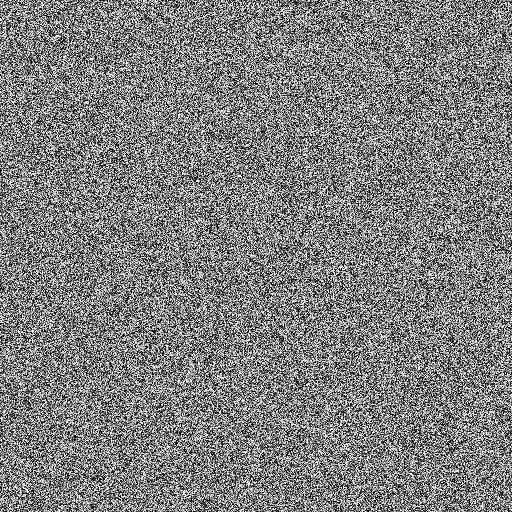

In [ ]:
image

In [ ]:
# Compress image
k_values = [5, 10, 20, 50,100]
results = compress_image_svd(image, k_values)

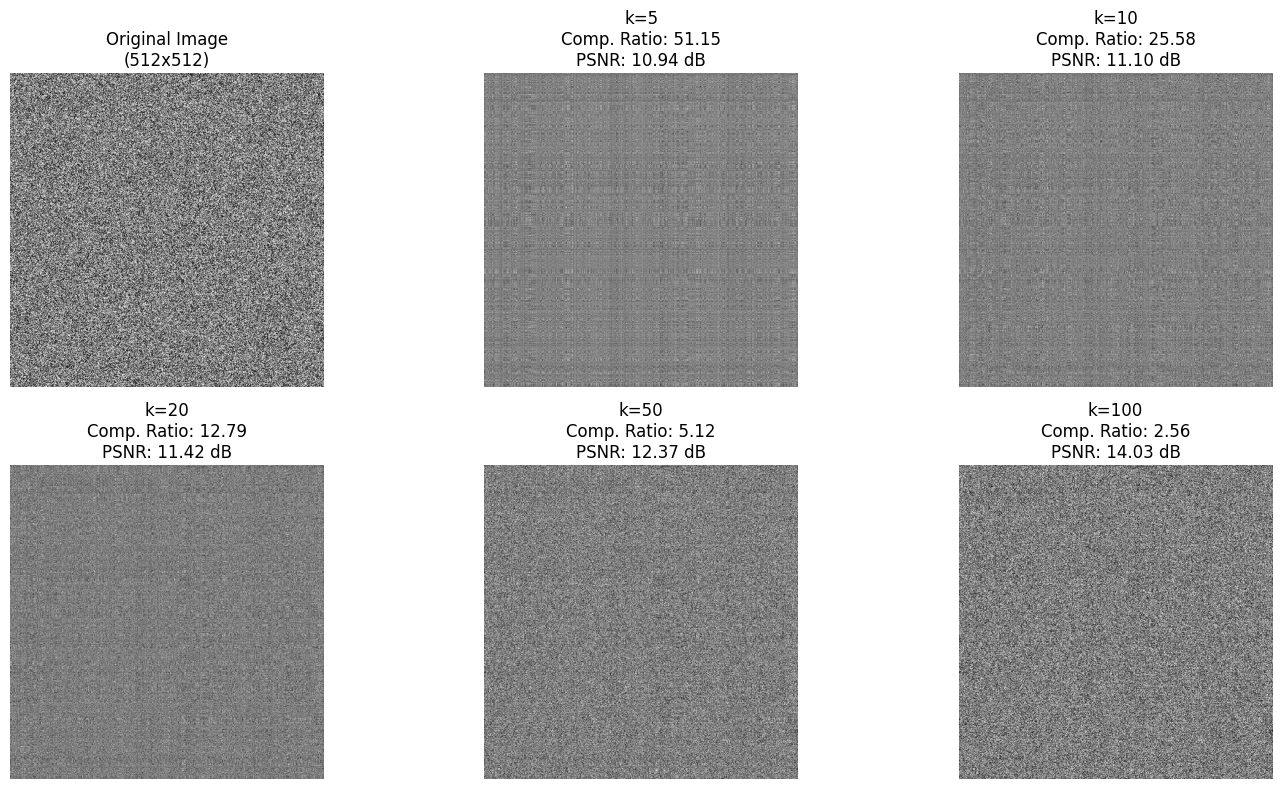

In [ ]:
# Visualize results
plt.figure(figsize=(15, 8))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image\n(512x512)')
plt.axis('off')

# Compressed images
for i, result in enumerate(results):
    plt.subplot(2, 3, i + 2)
    plt.imshow(result['image'], cmap='gray')
    plt.title(f'k={result["k"]}\nComp. Ratio: {result["compression_ratio"]:.2f}\nPSNR: {result["psnr"]:.2f} dB')
    plt.axis('off')

plt.tight_layout()

In [ ]:
# Print metrics
print("Compression Results:")
for result in results:
    print(f"k={result['k']}: Compression Ratio={result['compression_ratio']:.2f}, PSNR={result['psnr']:.2f} dB")

Compression Results:
k=5: Compression Ratio=51.15, PSNR=10.94 dB
k=10: Compression Ratio=25.58, PSNR=11.10 dB
k=20: Compression Ratio=12.79, PSNR=11.42 dB
k=50: Compression Ratio=5.12, PSNR=12.37 dB
k=100: Compression Ratio=2.56, PSNR=14.03 dB


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import time
import urllib.request
import zipfile
import os
from math import sqrt

In [90]:
def load_movielens_data():
    """Load MovieLens 100k dataset."""
    # URLs for MovieLens 100k dataset
    ratings_url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.data'
    movies_url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.item'

    # Load ratings (user_id, movie_id, rating, timestamp)
    ratings = pd.read_csv(ratings_url, sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

    # Load movie titles (movie_id, title, ...)
    movies = pd.read_csv(movies_url, sep='|', encoding='latin-1',
                         names=['movie_id', 'title'] + [f'col_{i}' for i in range(22)],
                         usecols=['movie_id', 'title'])

    return ratings, movies

ratings, movies = load_movielens_data()

In [91]:
def create_user_item_matrix(ratings, n_users, n_items):
    """Create user-item rating matrix."""
    R = np.zeros((n_users, n_items))
    for _, row in ratings.iterrows():
        user = int(row['user_id']) - 1  # 0-based indexing
        item = int(row['movie_id']) - 1
        R[user, item] = row['rating']
    return R

In [92]:
n_users = ratings['user_id'].max()
n_items = ratings['movie_id'].max()
R = create_user_item_matrix(ratings, n_users, n_items)

In [93]:
def recommendation_system(R, k_values=[5, 10, 20, 50], test_ratio=0.2):
    """Implement SVD-based recommendation system and evaluate predictions."""
    m, n = R.shape
    results = []

    # Split data into train and test sets
    np.random.seed(42)
    test_mask = np.random.rand(m, n) < test_ratio
    train_R = R.copy()
    train_R[test_mask] = 0  # Mask test ratings
    test_ratings = [(i, j, R[i, j]) for i in range(m) for j in range(n) if test_mask[i, j] and R[i, j] > 0]

    for k in k_values:
        # Compute SVD on training matrix
        U, Sigma, Vt = my_svd(train_R)

        # Truncate to k components
        U_k = U[:, :k]
        Sigma_k = Sigma[:k, :k]
        Vt_k = Vt[:k, :]

        # Reconstruct rating matrix
        R_pred = U_k @ Sigma_k @ Vt_k

        # Compute RMSE on test set
        y_true = [rating for _, _, rating in test_ratings]
        y_pred = [R_pred[i, j] for i, j, _ in test_ratings]
        rmse = sqrt(mean_squared_error(y_true, y_pred))

        results.append({
            'k': k,
            'R_pred': R_pred,
            'rmse': rmse
        })

    return results

In [94]:
k_values = [5, 10, 20, 50]
results = recommendation_system(R, k_values=k_values)

In [96]:
def get_top_n_recommendations(R_pred, user_id, movies, n=5, original_R=None):
    """Get top-N movie recommendations for a user."""
    # Get predicted ratings for the user
    user_ratings = R_pred[user_id - 1]  # 1-based user_id to 0-based index

    # If original_R is provided, exclude movies already rated by the user
    if original_R is not None:
        user_rated = original_R[user_id - 1] > 0
        user_ratings[user_rated] = -np.inf  # Exclude rated movies

    # Get indices of top-N movies
    top_indices = np.argsort(user_ratings)[::-1][:n]

    # Get movie titles and predicted ratings
    recommendations = []
    for idx in top_indices:
        movie_id = idx + 1  # 0-based to 1-based indexing
        movie_title = movies[movies['movie_id'] == movie_id]['title'].iloc[0]
        predicted_rating = user_ratings[idx]
        recommendations.append((movie_title, predicted_rating))

    return recommendations


**Submission Requirements**


> **A well-documented Jupyter notebook containing:**



1.All your implementations

2.Test cases and results

3.Visualizations where applicable

4.Performance analysis


---




>  **A short report (Latex) summarizing**



1.Your implementation approach

2.Key findings from the experiments

3.Challenges faced and how you addressed them